# Mask generating algorithm

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig, TrainingArguments, Trainer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

accelerator = Accelerator()
device = accelerator.device

# Load Model

In [2]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: golden retriever


# Load MaskGeneratingModel

In [3]:
from maskgen.vision_models.vision_maskgen_clip_v2 import MaskGeneratingModel
# Create the explainer g(x)
exp_base_model = ViTModel.from_pretrained(pretrained_name) 
mask_gen_model = MaskGeneratingModel(base_model=exp_base_model, hidden_size=config.hidden_size, num_classes=config.num_labels, config=None)
mask_gen_model.to(device)
# mask_gen_model.load_state_dict(torch.load('trained/vision_clip_step80_20241212-150002.pt'))
mask_gen_model.load_state_dict(torch.load('trained/brisk-water-58_vision_clip_20241218-155515.pt'))
# mask_gen_model.load_state_dict(torch.load('mask_gen_model/mask_gen_model_final_4_39.pth'))
mask_gen_model.eval()

patch_size = 14
print()

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/1034651.1.gpu/ipykernel_2740451/3823721849.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_sa

## Show Example

# Demo trained examples

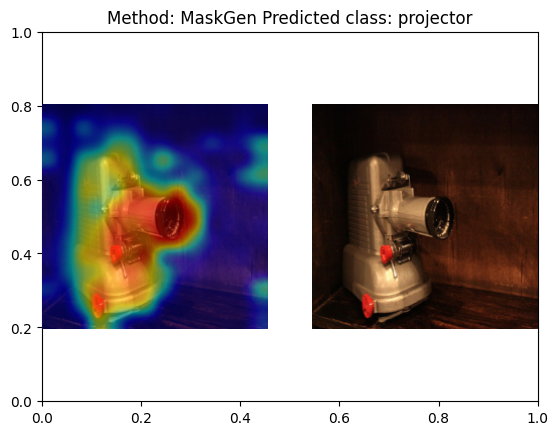

In [14]:
from maskgen.utils.img_utils import plot_overlap_np
import random

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
# url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
# url = "http://farm9.staticflickr.com/8490/8179481059_41be7bf062_z.jpg"
# url = "http://farm1.staticflickr.com/76/197438957_b20800e7cf_z.jpg"
# url = "http://farm3.staticflickr.com/2284/5730266001_7d051b01b7_z.jpg"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n01491361_tiger_shark.JPEG?raw=true"
# url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n03000684_chain_saw.JPEG?raw=true"
url = "https://github.com/EliSchwartz/imagenet-sample-images/blob/master/n04009552_projector.JPEG?raw=true"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = pred_model(img).logits.argmax(-1).item()
    secondary_class_idx = pred_model(img).logits.argsort(descending=True)[0][1].item()

# random number range from 0 to 999
# label = random.randint(0, 999)
# label = secondary_class_idx
label = predicted_class_idx
label = torch.tensor([label]).to(device)

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[label.item()]}")
dist, value, _ = mask_gen_model.get_dist_critic(img, label)
sim_logits = dist.logits
N = inputs['pixel_values'].shape[0]
size = 14

# heatmap = torch.sigmoid(sim_logits).reshape(N, size, size)
heatmap = mask_gen_model.attribute_img(img, label, image_size=224, patch_size=16)
# heatmap = sim_logits.reshape(N, size, size)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

In [15]:
print("heatmap_max", heatmap.max())
print("heatmap_min", heatmap.min())
print("heatmap_mean", heatmap.mean())

heatmap_max 0.9530154
heatmap_min 0.0013597024
heatmap_mean 0.28376257


In [42]:
# from maskgen.utils import idx_to_selector

# def get_sampled_heatmap(img, sim, pseudo_label, n_samples=10):
#     predicted_class_selector = idx_to_selector(pseudo_label, 1000)
#     sampled_mask_list = []
#     for _ in range(n_samples):
#         sampled_mask, sampled_mask_prob, _, _ = mask_gen_model.sample_one_step(img, sim, predicted_class_selector=predicted_class_selector)
#         sampled_mask_list.append(sampled_mask * sampled_mask_prob)

#     heatmap = torch.stack(sampled_mask_list).mean(0).reshape(-1, 16, 16)
#     return heatmap

# n_samples = 100
# with torch.no_grad():
#     inputs = processor(images=image, return_tensors="pt")
#     inputs.to(device)
#     img = inputs['pixel_values']
#     img = img.to(device)
#     pseudo_label = pred_model(img).logits.argmax(-1)
#     predicted_class_idx = pseudo_label.item()
    
#     sim = mask_gen_model(img)['sim']

# plt.title(f"MaskGen_G Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
# # heatmap = mask_gen_model.attribute_img(img, image_size=224, patch_size=14)
# # heatmap_list = [mask_gen_model.generate_mask(sim) for _ in range(n_samples)]

# # heatmap = torch.stack(heatmap_list).mean(0).reshape(-1, 16, 16)
# heatmap = get_sampled_heatmap(img, sim, pseudo_label, n_samples=n_samples)
# heatmap = heatmap.squeeze(0).detach().cpu().numpy()
# img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

# img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)
sim_logits

tensor([[-7.1245, -6.9893, -7.0170, -6.9508, -7.0132, -6.9531, -6.9393, -6.9286,
         -6.8818, -7.1008, -7.1336, -7.1331, -7.0000, -7.0320, -7.1805, -7.1056,
         -7.0258, -7.0528, -7.0720, -7.0049, -7.0682, -7.1618, -7.3790, -7.0435,
         -7.0598, -7.0847, -7.2218, -7.2007, -7.1155, -7.3119, -7.3039, -7.3126,
         -7.1203, -6.8697, -7.2868, -7.1642, -7.0941, -7.0119, -7.0118, -6.9895,
         -6.9172, -6.9647, -7.0492, -7.4035, -7.1646, -7.0948, -7.0877, -6.9825,
         -7.2497, -7.3033, -6.9727, -6.9567, -6.9651, -7.0910, -6.9238, -6.9384,
         -7.1142, -7.3566, -7.1474, -7.1682, -7.1169, -7.1674, -7.1983, -7.5450,
         -7.0725, -7.1030, -6.9820, -7.0355, -7.3702, -7.1380, -7.1606, -7.0706,
         -7.1075, -7.2072, -7.1862, -6.9959, -7.1173, -7.2334, -6.8852, -7.0098,
         -7.0142, -7.2117, -7.1607, -7.0879, -7.3978, -7.1142, -7.1969, -7.0964,
         -7.3012, -7.1346, -6.9650, -7.1603, -7.0180, -7.1596, -7.1523, -7.1535,
         -7.1949, -7.1081, -

# Batch Evaluation

In [18]:
from torch.utils.data import DataLoader

def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)
train_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 100
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
# test_dataloader = DataLoader(train_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


In [17]:
from maskgen.evaluation import EvalGame
from tqdm import tqdm

n_samples = 100

# random_mask
root_path = 'results/maskgen-vit'
topk = 20

eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)

def save_heatmap(heatmap, batch_size, idx, root_path):
    # convert to numpy
    heatmap = heatmap.detach().cpu().numpy() # [N, 1, 14, 14]
    tail_index = batch_size * (idx + 1)
    file_name = os.path.join(root_path, f"heatmap-{tail_index}")
    np.save(file_name, heatmap)
    
    return 0


# def get_sampled_heatmap(img, sim, pseudo_label, n_samples=10):
#     predicted_class_selector = idx_to_selector(pseudo_label, 1000)
#     sampled_mask_list = []
#     for _ in range(n_samples):
#         sampled_mask, sampled_mask_prob, _, _ = mask_gen_model.sample_one_step(img, sim, predicted_class_selector=predicted_class_selector)
#         sampled_mask_list.append(sampled_mask * sampled_mask_prob)

#     heatmap = torch.stack(sampled_mask_list).mean(0).reshape(-1, 16, 16)
#     return heatmap
    

ins_score_list = []
del_score_list = []
heatmap_list = []


for idx, data in tqdm(enumerate(test_dataloader)):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = pred_model(pixel_values).logits.argmax(-1).view(-1)

    # sum up all 3 RGB channels for heatmap
    attr = mask_gen_model.attribute_img(pixel_values, image_size=224, patch_size=patch_size) # [1,14,14]
    # sim = mask_gen_model(pixel_values)['sim']
    # attr = get_sampled_heatmap(pixel_values, sim, pseudo_label, n_samples=n_samples)


    # heatmap = attr.squeeze(1) # [1, 14, 14]
    heatmap = attr # [1, 14, 14]
    # heatmap = heatmap.squeeze(0).detach().cpu().numpy()
    heatmap_list.append(heatmap)
    if (idx + 1) * batch_size % 100 == 0:
        heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 14, 14)
        save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)
        heatmap_list = []

    with torch.no_grad():
        input_img = pixel_values
        ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
        del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

        # append to list
        ins_score_list.append(ins_score)
        del_score_list.append(del_score)
    
    if idx >= 3:
        break

if len(heatmap_list) > 0:
    heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
    save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)



0it [00:00, ?it/s]


TypeError: MaskGeneratingModel.attribute_img() missing 1 required positional argument: 'labels'

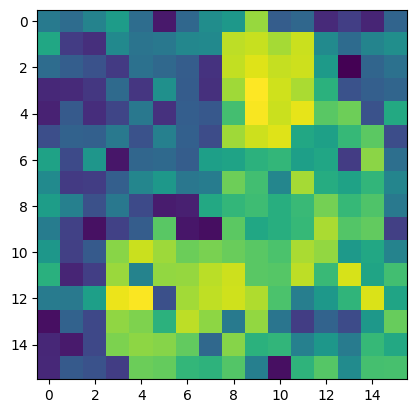

In [19]:
plt.imshow(heatmap[1].detach().cpu().numpy())

In [20]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)

print(ins_score.mean())
print(del_score.mean())
# heatmap = heatmap.squeeze(0).detach().cpu().numpy()
# img = input_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

# img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)
# tensor(0.6749, device='cuda:0')
# tensor(0.0431, device='cuda:0')

tensor(0.3437, device='cuda:0')
tensor(0.3038, device='cuda:0')


Predicted class: dumbbell


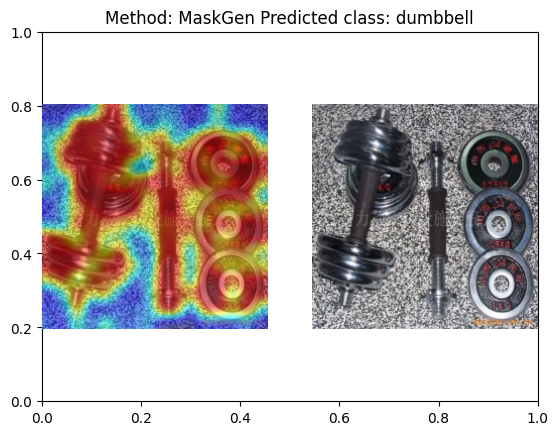

ins_score: tensor(0.0008, device='cuda:0')
del_score: tensor(0.9168, device='cuda:0')


In [23]:
from maskgen.utils.img_utils import plot_overlap_np

idx = 3

predicted_class_idx = pseudo_label[idx].item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

hm = heatmap[idx].detach().cpu().numpy()
img = input_img[idx].detach().cpu().numpy().transpose(1, 2, 0)

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
plt.annotate(f"ins_score: {ins_score_list[-1][idx]:.4f}", (0, 10))
plt.annotate(f"del_score: {del_score_list[-1][idx]:.4f}", (0, 20))

img_int, heatmap_img = plot_overlap_np(img, hm, mean, std)

print("ins_score:", ins_score_list[-1][idx])
print("del_score:", del_score_list[-1][idx])

In [30]:
heatmap[idx]

tensor([[0.1053, 0.1067, 0.1125, 0.1142, 0.1140, 0.1154, 0.1224, 0.1234, 0.1182,
         0.1177, 0.1155, 0.1118, 0.1050, 0.1023],
        [0.1161, 0.1256, 0.1299, 0.1418, 0.1551, 0.1624, 0.1607, 0.1667, 0.1536,
         0.1448, 0.1378, 0.1280, 0.1176, 0.1149],
        [0.1245, 0.1334, 0.1447, 0.1487, 0.1916, 0.1930, 0.1987, 0.1879, 0.1922,
         0.1819, 0.1600, 0.1460, 0.1294, 0.1181],
        [0.1255, 0.1501, 0.1583, 0.1745, 0.2202, 0.2357, 0.2252, 0.2380, 0.2191,
         0.2021, 0.1848, 0.1643, 0.1493, 0.1198],
        [0.1324, 0.1703, 0.1812, 0.2148, 0.2454, 0.2601, 0.2793, 0.2589, 0.2646,
         0.2335, 0.2048, 0.1778, 0.1482, 0.1267],
        [0.1315, 0.1618, 0.1868, 0.2292, 0.2508, 0.2855, 0.2868, 0.2934, 0.2679,
         0.2685, 0.2193, 0.1781, 0.1450, 0.1284],
        [0.1382, 0.1670, 0.2038, 0.2404, 0.2544, 0.3101, 0.3243, 0.3046, 0.2962,
         0.2526, 0.2283, 0.1918, 0.1445, 0.1299],
        [0.1409, 0.1651, 0.2009, 0.2342, 0.2734, 0.2815, 0.3062, 0.2905, 0.2741,
  

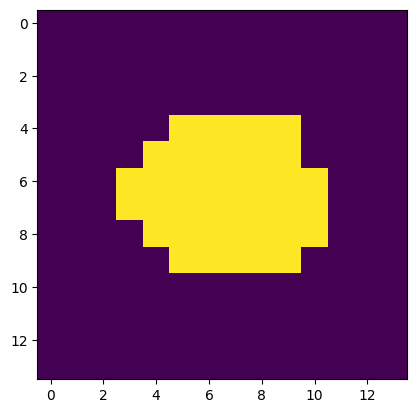

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


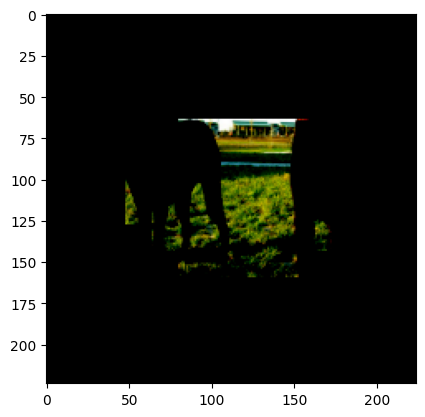

In [17]:
from maskgen.evaluation import obtain_masks_on_topk, obtain_masked_input_on_topk

test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]

mode = 'ins'
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode)
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode)

# plt.imshow((heatmap[idx] > torch.quantile(heatmap[idx], 0.8)).float().cpu().numpy())
plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
plt.show()
plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.show()

In [18]:
from maskgen.evaluation import EvalGame, obtain_masks_on_topk, obtain_masked_input_on_topk
test_img = input_img[idx:idx+1]
test_heatmap = heatmap[idx:idx+1]
# eval_game.get_deletion_at_topk(test_img, test_heatmap, topk)
test_mask = obtain_masks_on_topk(test_heatmap, topk, mode='del')
test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk)
 # [N, 1, H_a, W_a]
resized_mask = F.interpolate(test_mask.unsqueeze(1), size=test_img.shape[-2:], mode='nearest')

test_predicted_class_idx = pred_model(test_masked_img).logits.argmax(-1)
print("Predicted class:", pred_model.config.id2label[test_predicted_class_idx.item()])

# probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
# print(eval_game.get_score_at_topk(test_img, test_heatmap, 20, mode='del'))

test_masked_img = obtain_masked_input_on_topk(test_img, test_heatmap, topk, mode='del')
probs = F.softmax(pred_model(test_masked_img).logits, dim=-1)
print(probs[:,439])


test_masked_img = obtain_masked_input_on_topk(test_img, test_mask, topk)


pseudo_label = self.model(x).argmax(-1) # [1, 1]
probs = torch.softmax(self.model(masked_input), dim=-1) # [N, 1000]

selector = idx_to_selector(pseudo_label, self.output_dim) # [N, 1000]
probs = (probs * selector).sum(-1) # [N,]
return probs # [N,]



plt.imshow(test_masked_img[0].detach().cpu().numpy().transpose(1, 2, 0))
# plt.imshow(test_mask.detach().cpu().numpy().squeeze(0))
# plt.imshow((test_masked_img * resized_mask)[0].detach().cpu().numpy().transpose(1, 2, 0))

Predicted class: curly-coated retriever
tensor([5.2906e-05], device='cuda:0')


NameError: name 'self' is not defined

In [ ]:
# from evaluation import EvalGame
# import os 
# import re
# from tqdm import tqdm


# root_path = 'results/mask-vit'
# model = lambda x: pred_model(pixel_values=x).logits
# eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)
# topk = 50

# def extract_number(filename):
#     """
#     Extract the first occurance of countinuous numbers in a file name
#     """
#     match = re.search(r'\d+', filename)
#     if match:
#         return int(match.group(0))
#     return 0

# def get_ordered_filename_list(root_path):
#     file_path_list = []
#     for filename in os.listdir(root_path):
#         if filename.endswith('.npy'):
#             file_path = os.path.join(root_path, filename)
#             file_path_list.append(file_path)
#     file_path_list = sorted(file_path_list, key=extract_number)
#     return file_path_list


# def load_heatmap(root_path):
#     file_path_list = get_ordered_filename_list(root_path)
#     for filename in file_path_list:
#        yield np.load(filename)


# ins_score_list = []
# del_score_list = []

# heatmap_generator = load_heatmap(root_path)
# test_dataloader_iterator = iter(test_dataloader)
# for idx, data in tqdm(enumerate(heatmap_generator)):
#     heatmap = torch.tensor(data, device=device)

#     with torch.no_grad():
#         # Average pooling to convert to 14*14 heatmap
#         heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
#         input_img = next(test_dataloader_iterator)['pixel_values'].to(device)
#         ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
#         del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

#         # append to list
#         ins_score_list.append(ins_score)
#         del_score_list.append(del_score)